# Quickstart Tutorial

In this tutorial, we show how to quickly set up and train an RNN regression model with the deep4cast package. The goal is to show you how to handle the package interface and inspect the model object after training. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.metrics import adjust_for_horizon, mape
from pandas import read_table

%matplotlib inline

/Users/shirleyren/Development/deep4cast/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

In [3]:
# Set lookback window for truncated sample time series
lag = 20 # i.e. 20 months
horizon = 1 # one-month ahead forecasting
test_fraction = 0.15
test_length = int(len(df) * test_fraction)
train_length = len(df) - test_length

# Prepare train and test set
ts = df.astype('float32').values
ts = np.expand_dims(ts, axis=-1)
ts_train = ts[:-test_length]
ts_test = ts[-test_length - lag:]

In [4]:
metric = adjust_for_horizon(mape)
def criticize_model(forecaster, metric):
    ts_train_pred = forecaster.predict(ts_train)['mean']
    ts_test_pred = forecaster.predict(ts_test)['mean']
    print('TRAIN \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(ts_train_pred, ts[lag:train_length])))
    print('TEST \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(ts_test_pred, ts[train_length:])))

Before we do anything, we should probably quickly visualize the data.

Text(0.5,1,'Black: training time series; Red: testing time series')

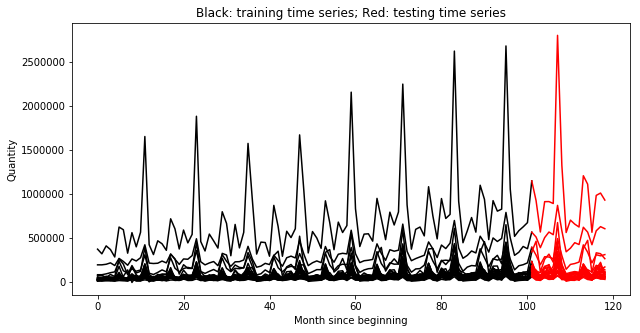

In [5]:
# Plot dataset
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length,:,0], 'k')
plt.plot(range(len(ts[:train_length-1,:,0]), len(ts)), ts[train_length-1:,:,0], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

## Recurrent Neural Network Forecaster

Now that we have cleaned and prepared out dataset we can proceed to fit one of our built-in regression models. Here, we choose the truncated RNN, which means that the training example time series have finite length. The model is initalized with
* a topology object,
* an optimizer,
* a lag length (lookback window),
* a forecasting horizon, 
* a batch size that determines the number of training example fed into the optimizer per training batch,
* a number of epochs that specifies how many trianing batches are processed,
* and a learning rate.

In [6]:
# Hyper-parameters
topology = [
    {
        'meta': {'layer_type': 'GRU', 'layer_id': 'g1', 'parent_ids': ['input']},
        'params': {'units': 128, 'return_sequences': True}
    },
    {
        'meta': {'layer_type': 'GRU', 'layer_id': 'g2', 'parent_ids': ['g1']},
        'params': {'units': 128, 'return_sequences': False}
    }
]

# Instantiate regression model
forecaster = Forecaster(
    topology,
    optimizer='rmsprop',
    lag=lag,
    horizon=horizon,
    batch_size=8,
    epochs=50,
    lr=0.01
)
forecaster.fit(ts_train)

Let's have a peek at what the model training and testing errors look like

In [7]:
criticize_model(forecaster, metric)

Uncertainty is set to False. Only mean prediction isgenerated. If confidence intervals are desired, please set'uncertainty' to True when initializing the Forecaster
Uncertainty is set to False. Only mean prediction isgenerated. If confidence intervals are desired, please set'uncertainty' to True when initializing the Forecaster
TRAIN 	 Mean Absolute Percentage Error: 29.1%
TEST 	 Mean Absolute Percentage Error: 26.2%


Let's have a look at the history of the training loss (here mean-squared error)

Text(0,0.5,'Mean-squared training error')

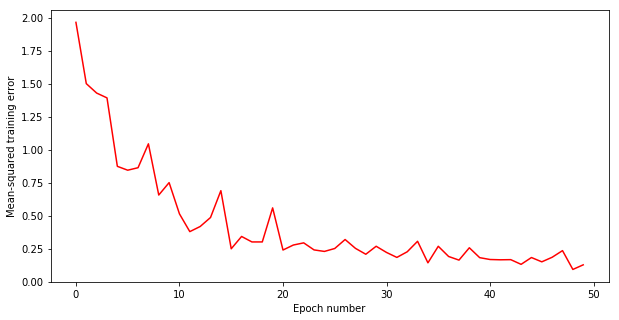

In [8]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Predictions for truncated RNN

Let's now take the model to make some predictions and compare visually with the test data.

In [9]:
ts_pred = forecaster.predict(ts_test)
ts_pred_mean = ts_pred['mean']

Uncertainty is set to False. Only mean prediction isgenerated. If confidence intervals are desired, please set'uncertainty' to True when initializing the Forecaster


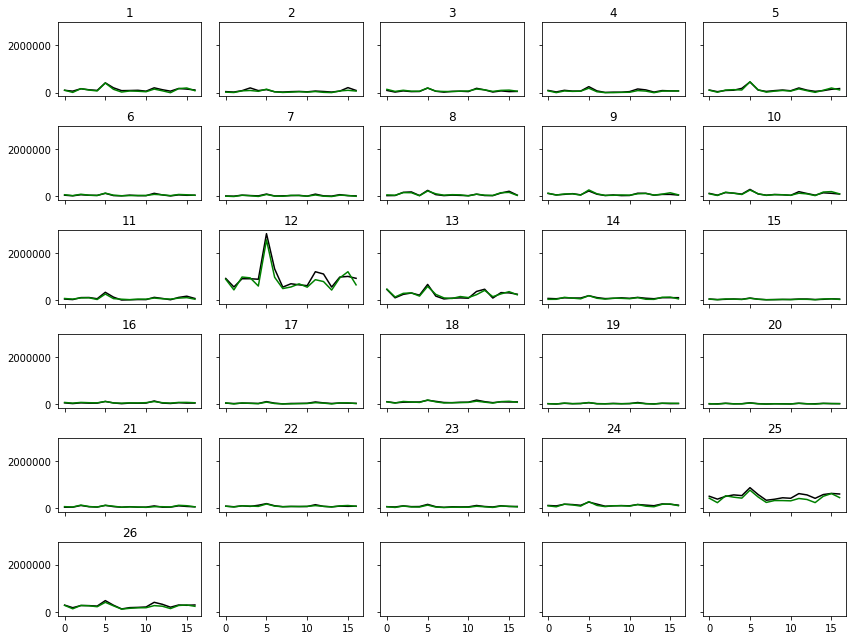

In [10]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, title in zip(axes.flat, 
                                                 ts[train_length:,:,0].T, 
                                                 ts_pred_mean[:,:,0].T, 
                                                 range(1,26+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.set_title(title)

plt.tight_layout()